# Epipolar_Geometry.ipynb
__Description:__ Notebook details how to answer questions for section 2.2.<br>
__Author:__ Matthew Lesko-Krleza<br>
__Course:__ ECSE 415<br>
__Assignment:__ Assignment #3

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img_left = cv2.cvtColor(cv2.imread('./Aloe/view1.png'), cv2.COLOR_BGR2RGB)
# img_right = cv2.cvtColor(cv2.imread('./Aloe/view5.png'), cv2.COLOR_BGR2RGB)

img_left = cv2.imread('./Bowling1/view1.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('./Bowling1/view5.png', cv2.IMREAD_GRAYSCALE)

In [16]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

### Question 2 Stereo Vision

#### Question 2.2 Epipolar Geometry

Question 2.2.1 Compute matching SIFT keypoints from a stereo image pair

In [17]:
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_left, descriptors_left = sift_obj.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift_obj.detectAndCompute(img_right, None)

img_keypoints_left = img_left.copy()
img_keypoints_right = img_right.copy()

cv2.drawKeypoints(img_left, 
                  keypoints_left, 
                  img_keypoints_left, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_right,
                  keypoints_right, 
                  img_keypoints_right, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

bfMatcher = cv2.BFMatcher(cv2.NORM_L2)
matches = bfMatcher.knnMatch(descriptors_left, descriptors_right, k=2)

Question 2.2.2 Compute epipolar lines for both images

In [18]:
# ratio test - store the list of best matches from both images
good = []
points_left = []
points_right = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        points_right.append(keypoints_right[m.trainIdx].pt)
        points_left.append(keypoints_left[m.queryIdx].pt)

# find the Fundamental Matrix
points_left = np.int32(points_left)
points_right = np.int32(points_right)
F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_LMEDS)

# Use only inliers for remaining computations
points_left = points_left[mask.ravel()==1]
points_right = points_right[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
lines_left = cv2.computeCorrespondEpilines(points_right, 2, F)
lines_left = lines_left.reshape(-1, 3)
# draw lines
img_left1, img_right1 = drawlines(img_left, img_right, lines_left, points_left, points_right)

lines_right = cv2.computeCorrespondEpilines(points_left, 1, F)
lines_right = lines_right.reshape(-1, 3)
# draw lines
img_right2, img_left2 = drawlines(img_right, img_left, lines_right, points_right, points_left)

Display epipolar lines for both images

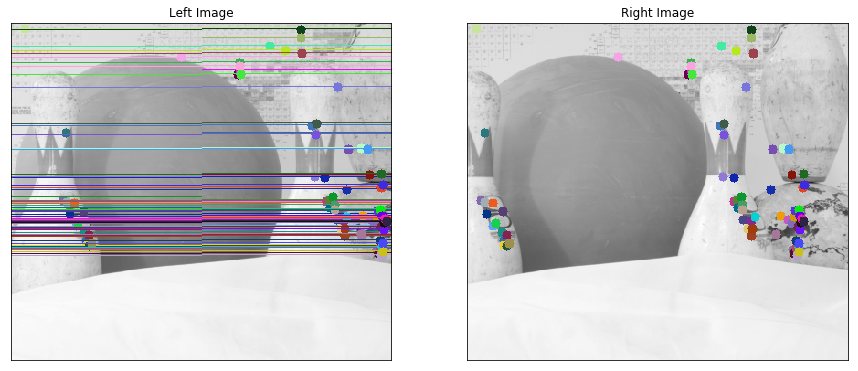

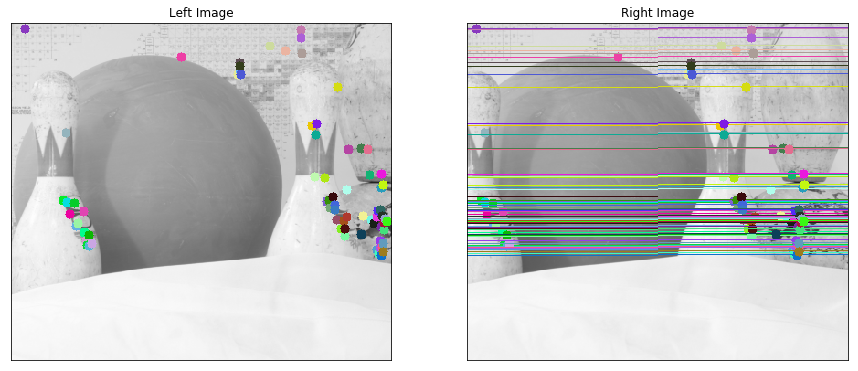

In [20]:
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_left1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_right1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_left2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_right2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Question 2.2.3 Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around the keypoint in the right image.

As one can see, the match all the way at the top left corner of the right image has to be an incorrect match, because translating the left image's camera to the right would necessarily remove that patch.

In [19]:
x, y = points_right[0]
patch = img_right[x - 2 : x + 3, y - 2 : y + 3]
print(patch)

[[220 190 177 179 177]
 [220 190 180 184 186]
 [220 209 209 215 217]
 [220 213 220 220 220]
 [220 215 219 220 220]]


Question 2.2.4 Match the extracted patch using SSD with every patch along the corresponding epipolar line in the left image.

In [21]:
epi_line = lines_left[0]
print(epi_line)

[ 9.148887e-17  1.000000e+00 -7.000000e+00]
